# [`ml4gw`](https://github.com/ML4GW/ml4gw) Tutorial

This tutorial has two parts:
1. An overview of many of the features of `ml4gw`, with demonstrations
2. An example of training a model using these features

**Requirements:** This notebook requires a number of packages besides `ml4gw` to run completely.
Install with:

```bash
pip install "ml4gw>=0.7.6" "gwpy>=3.0" "h5py>=3.12" "torchmetrics>=1.6" "lightning>=2.4.0" "rich>=10.2.2,<14.0"


## Overview

We'll go through this as though our goal is to build a binary black hole detection model, 
with some excursions to look at other features. Much of this is similar to how the [Aframe](https://www.github.com/ML4GW/aframe) algorithm works.
The development of `ml4gw` was guided by what was needed for Aframe,
which makes BBH detection a good test case.

Goals of this tutorial:
- Introduce and demonstrate how to interact with many of the features of `ml4gw`
- Explain why these tools are useful for doing machine learning in gravitational wave physics
- Present areas where it may be possible to contribute to `ml4gw`

In [1]:
import torch
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "text.usetex": False,
        # "font.family": "Computer Modern",
        "font.size": 16,
        "figure.dpi": 100,
    }
)

# Most of this notebook can be run on CPU in a reasonable amount of time.
# The example training at the end cannot be.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from ml4gw.distributions import PowerLaw, Sine, Cosine, DeltaFunction, UniformComovingVolume
from torch.distributions import Uniform
from ml4gw.waveforms import IMRPhenomD
from ml4gw.waveforms.generator import TimeDomainCBCWaveformGenerator
from ml4gw.waveforms.conversion import chirp_mass_and_mass_ratio_to_components
from ml4gw.gw import get_ifo_geometry, compute_observed_strain
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from pathlib import Path
from ml4gw.transforms import SpectralDensity
import h5py
from ml4gw.gw import compute_ifo_snr, compute_network_snr
from ml4gw.gw import reweight_snrs
from ml4gw.dataloading import Hdf5TimeSeriesDataset
from ml4gw.transforms import Whiten

data_dir = Path("./data")

# # And this to the directory where you want to download the data
background_dir = data_dir / "background_data"



param_dict = {
    "chirp_mass": Uniform(1.17, 2.2),
    "mass_ratio": Uniform(0.6, 1.0),
    "chi1": Uniform(-0.05, 0.05),
    "chi2": Uniform(-0.05, 0.05),
    "distance": UniformComovingVolume(10,500,distance_type='luminosity_distance'),
    "phic": DeltaFunction(0),
    "inclination": Sine(),
}

In [20]:
# Desired duration of time-domain waveform
waveform_duration = 60
# Sample rate of all the data we'll be using today
sample_rate = 2048

# Define minimum, maximum, and reference frequencies
f_min = 20
f_max = 1024
f_ref = 20

nyquist = sample_rate / 2
num_samples = int(waveform_duration * sample_rate)
num_freqs = num_samples // 2 + 1

# Create an array of frequency values at which to generate our waveform
# At the moment, only frequency-domain approximants have been implemented
frequencies = torch.linspace(0, nyquist, num_freqs).to(device)
freq_mask = (frequencies >= f_min) * (frequencies < f_max).to(device)

In [21]:
num_waveforms = 100
params = {
    k: v.sample((num_waveforms,)).to(device) for k, v in param_dict.items()
}

approximant = IMRPhenomD().to(device)

# Calling the approximant with the frequency array, reference frequency, and waveform parameters
# returns the cross and plus polarizations
hc_f, hp_f = approximant(f=frequencies[freq_mask], f_ref=f_ref, **params)
print(hc_f.shape, hp_f.shape)

# The generated waveform goes through high-pass filter, removing low frequency content (TimeDomainCBCWaveformGenerator)
waveform_generator = TimeDomainCBCWaveformGenerator(
    approximant=approximant,
    sample_rate=sample_rate,
    f_min=f_min,
    duration=waveform_duration,
    right_pad=0.5,
    f_ref=f_ref,
).to(device)

params["mass_1"], params["mass_2"] = chirp_mass_and_mass_ratio_to_components(
    params["chirp_mass"], params["mass_ratio"]
)

params["s1z"], params["s2z"] = params["chi1"], params["chi2"]

hc, hp = waveform_generator(**params)
print(hc.shape, hp.shape)

torch.Size([100, 60240]) torch.Size([100, 60240])
torch.Size([100, 122880]) torch.Size([100, 122880])


In [3]:
!nvidia-smi

Sat Aug 16 11:12:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    On  |   00000000:CA:00.0 Off |                    0 |
| N/A   30C    P8             32W /  350W |       3MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Architectures

We've implemented a couple basic [neural network architectures](https://github.com/ML4GW/ml4gw/tree/main/ml4gw/nn) for out-of-the-box convenience. Today, we'll be using a 1D ResNet, which is mostly copied from PyTorch's implementation, but with a few key differences:
- Arbitrary kernel sizes
- `GroupNorm` as the default normalization layer, as training statistics in general won't match testing statistics
- Custom `GroupNorm` implementation which is faster than the standard PyTorch version at inference time

In [3]:
from ml4gw.nn.resnet import ResNet1D

architecture = ResNet1D(
    in_channels=2,  # H1 and L1 as input channels
    layers=[2, 2],  # Keep things small and do a ResNet10
    classes=1,  # Single scalar-valued output
    kernel_size=3,  # Size of convolutional kernels, not to be confused with data size
).to(device)

# And we can, e.g., pass the first element of our validation set
# with torch.no_grad():
#     print(architecture(whitened_injected[0][None]))

## Example training setup

We'll now go through an example of putting many of these pieces together into a single model, implemented using th [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) framework.

Begin by clearing the GPU:

In [4]:
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

In [ ]:
from ml4gw import augmentations, distributions, gw, transforms, waveforms
from ml4gw.dataloading import ChunkedTimeSeriesDataset, Hdf5TimeSeriesDataset
from ml4gw.utils.slicing import sample_kernels
import torch
from lightning import pytorch as pl
import torchmetrics
from torchmetrics.classification import BinaryAUROC

from typing import Callable, Dict, List


class Ml4gwDetectionModel(pl.LightningModule):
    """
    Model with methods for generating waveforms and
    performing our preprocessing augmentations in
    real-time on the GPU. Also loads training background
    in chunks from disk, then samples batches from chunks.
    """

    def __init__(
        self,
        architecture: torch.nn.Module,
        metric: torchmetrics.Metric,
        ifos: List[str] = ["H1", "L1"],
        kernel_length: float = 1.5, # this should the aframe window ()
        # PSD/whitening args
        fduration: float = 2,
        psd_length: float = 16, 
        sample_rate: float = 2048,
        fftlength: float = 2, # would we change this for BNS
        highpass: float = 32,
        # Dataloading args
        chunk_length: float = 128,  # we'll talk about chunks in a second
        reads_per_chunk: int = 40,
        learning_rate: float = 0.005,
        batch_size: int = 256,
        # Waveform generation args
        waveform_prob: float = 0.5,
        approximant: Callable = waveforms.cbc.IMRPhenomD,
        param_dict: Dict[str, torch.distributions.Distribution] = param_dict,
        waveform_duration: float = 60,
        f_min: float = 20,
        f_max: float = None,
        f_ref: float = 20,
        # Augmentation args
        inversion_prob: float = 0.5,
        reversal_prob: float = 0.5,
        min_snr: float = 30,
        max_snr: float = 100,
        snr_dist: str = "powerlaw",
        # Downsampling the injected signal
        variable_rate: bool = False,
        # Validation dataset
        val_filename: str = "validation_dataset.hdf5",
    ) -> None:
        super().__init__()
        self.save_hyperparameters(
            ignore=["architecture", "metric", "approximant"]
        )
        self.nn = architecture
        self.metric = metric
        self.variable_rate = variable_rate

        self.inverter = augmentations.SignalInverter(prob=inversion_prob)
        self.reverser = augmentations.SignalReverser(prob=reversal_prob)

        # real-time transformations defined with torch Modules
        self.spectral_density = transforms.SpectralDensity(
            sample_rate, fftlength, average="median", fast=False
        )
        self.whitener = transforms.Whiten(
            fduration, sample_rate, highpass=highpass
        )

        # get some geometry information about
        # the interferometers we're going to project to
        detector_tensors, vertices = gw.get_ifo_geometry(*ifos)
        self.register_buffer("detector_tensors", detector_tensors)
        self.register_buffer("detector_vertices", vertices)

        # define some sky parameter distributions
        self.param_dict = param_dict
        self.dec = distributions.Cosine()
        self.psi = torch.distributions.Uniform(0, torch.pi)
        self.phi = torch.distributions.Uniform(
            -torch.pi, torch.pi
        )  # relative RAs of detector and source
        self.waveform_generator = TimeDomainCBCWaveformGenerator(
            approximant=approximant(),
            sample_rate=sample_rate,
            duration=waveform_duration,
            f_min=f_min,
            f_ref=f_ref,
            right_pad=0.5,
        ).to(self.device)

        # rather than sample distances, we'll sample target SNRs.
        # This way we can ensure we train our network on
        # signals that are more detectable. We'll use a distribution
        # that looks roughly like the natural sampled SNR distribution
        # self.snr = distributions.PowerLaw(min_snr, max_snr, -3)

        # define SNR distribution
        if snr_dist.lower() == "uniform":
            self.snr = torch.distributions.Uniform(min_snr, max_snr)
        elif snr_dist.lower() == "powerlaw":
            self.snr = distributions.PowerLaw(min_snr, max_snr, -3)
        else:
            raise ValueError(f"Unknown snr_dist {snr_dist}, must be 'uniform' or 'powerlaw'")

        # up front let's define some properties in units of samples
        # Note the different usage of window_size from earlier
        self.kernel_size = int(kernel_length * sample_rate)
        self.window_size = self.kernel_size + int(fduration * sample_rate)
        self.psd_size = int(psd_length * sample_rate)

        # validation dataset file
        self.val_filename = val_filename

    def forward(self, X):
        return self.nn(X)

    def training_step(self, batch):
        X, y = batch
        y_hat = self(X)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch):
        X, y = batch
        y_hat = self(X)
        self.metric.update(y_hat, y)
        self.log("valid_auroc", self.metric, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        parameters = self.nn.parameters()
        optimizer = torch.optim.AdamW(parameters, self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.hparams.learning_rate,
            pct_start=0.1,
            total_steps=self.trainer.estimated_stepping_batches,
        )
        scheduler_config = dict(scheduler=scheduler, interval="step")
        return dict(optimizer=optimizer, lr_scheduler=scheduler_config)

    def configure_callbacks(self):
        chkpt = pl.callbacks.ModelCheckpoint(monitor="valid_auroc", save_top_k=10, mode="max")
        return [chkpt]

    def generate_waveforms(self, batch_size: int) -> tuple[torch.Tensor, ...]:
        rvs = torch.rand(size=(batch_size,))
        mask = rvs < self.hparams.waveform_prob
        num_injections = mask.sum().item()

        params = {
            k: v.sample((num_injections,)).to(device)
            for k, v in self.param_dict.items()
        }

        params["s1z"], params["s2z"] = (
            params["chi1"], params["chi2"]
        )
        params["mass_1"], params["mass_2"] = waveforms.conversion.chirp_mass_and_mass_ratio_to_components(
            params["chirp_mass"], params["mass_ratio"]
        )

        hc, hp = self.waveform_generator(**params)
        return hc, hp, mask

    def project_waveforms(
        self, hc: torch.Tensor, hp: torch.Tensor
    ) -> torch.Tensor:
        # sample sky parameters
        N = len(hc)
        dec = self.dec.sample((N,)).to(hc)
        psi = self.psi.sample((N,)).to(hc)
        phi = self.phi.sample((N,)).to(hc)

        # project to interferometer response
        return gw.compute_observed_strain(
            dec=dec,
            psi=psi,
            phi=phi,
            detector_tensors=self.detector_tensors,
            detector_vertices=self.detector_vertices,
            sample_rate=self.hparams.sample_rate,
            cross=hc,
            plus=hp,
        )

    def rescale_snrs(
        self, responses: torch.Tensor, psd: torch.Tensor
    ) -> torch.Tensor:
        # make sure everything has the same number of frequency bins
        num_freqs = int(responses.size(-1) // 2) + 1
        if psd.size(-1) != num_freqs:
            psd = torch.nn.functional.interpolate(
                psd, size=(num_freqs,), mode="linear"
            )
        N = len(responses)
        target_snrs = self.snr.sample((N,)).to(responses.device)
        return gw.reweight_snrs(
            responses=responses.double(),
            target_snrs=target_snrs,
            psd=psd,
            sample_rate=self.hparams.sample_rate,
            highpass=self.hparams.highpass,
        )

    def sample_waveforms(self, responses: torch.Tensor) -> torch.Tensor:
        pad = int((self.hparams.fduration / 2) * self.hparams.sample_rate)
        responses = torch.nn.functional.pad(responses, [pad, pad])
        return responses[-int(self.window_size * self.hparams.sample_rate):]

        # slice off random views of each waveform to inject in arbitrary positions
        #responses = responses[:, :, -self.window_size :]

        # pad so that at least half the kernel always contains signals
        #pad = [0, int(self.window_size // 2)]
        # pad = [0,int(0.5*self.hparams.sample_rate)] # padding half a second to the right, waveform generator had the merger 0.5s to the left of the edge
        #responses = torch.nn.functional.pad(responses, pad)
        #return sample_kernels(responses, self.window_size, coincident=True)

    def build_variable_indices(self, sr=2048, schedule=None, device=None):
        if schedule is None:
            schedule = torch.tensor([[0, 40, 256],
                                    [40, 58, 512],
                                    [58, 60, 2048]], dtype=torch.int, device=device)

        idx = torch.tensor([], dtype=torch.long, device=device)
        for s in schedule:
            if idx.size()[0] == 0:
                start = int(s[0] * sr)
            else:
                start = int(idx[-1]) + int(idx[-1] - idx[-2])
            stop = int(start + (s[1] - s[0]) * sr)
            step = int(sr // s[2])
            idx = torch.cat((idx, torch.arange(start, stop, step, dtype=torch.int, device=device)))
        return idx

    @torch.no_grad()
    def augment(self, X: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # break off "background" from target kernel and compute its PSD
        # (in double precision since our scale is so small)
        background, X = torch.split(
            X, [self.psd_size, self.window_size], dim=-1
        )
        psd = self.spectral_density(background.double())

        # Generate at most batch_size signals from our parameter distributions
        # Keep a mask that indicates which rows to inject in
        batch_size = X.size(0)
        hc, hp, mask = self.generate_waveforms(batch_size)
        hc, hp, mask = hc, hp, mask

        # Augment with inversion and reversal
        X = self.inverter(X)
        X = self.reverser(X)

        # sample sky parameters and project to responses, then
        # rescale the response according to a randomly sampled SNR
        responses = self.project_waveforms(hc, hp)
        responses = self.rescale_snrs(responses, psd[mask])

        # randomly slice out a window of the waveform, add it
        # to our background, then whiten everything
        responses = self.sample_waveforms(responses)
        # print(responses.shape, X.shape)

        X[mask] += responses.float()
        X = self.whitener(X, psd)

        # this is where I implement the downsampling for the dataset
        if self.variable_rate:
            indices = self.build_variable_indices(
                sr=self.hparams.sample_rate,
                device=X.device)
            
            X = X.index_select(dim=-1, index=indices)

        # create labels, marking 1s where we injected
        y = torch.zeros((batch_size, 1), device=X.device)
        y[mask] = 1
        return X, y

    def on_after_batch_transfer(self, batch, _):
        # this is a parent method that lightning calls
        # between when the batch gets moved to GPU and
        # when it gets passed to the training_step.
        # Apply our augmentations here
        if self.trainer.training:
            batch = self.augment(batch)
        return batch

    def train_dataloader(self):
        # Because our entire training dataset is generated
        # on the fly, the traditional idea of an "epoch"
        # meaning one pass through the training set doesn't
        # apply here. Instead, we have to set the number
        # of batches per epoch ourselves, which really
        # just amounts to deciding how often we want
        # to run over the validation dataset.
        samples_per_epoch = 3000
        batches_per_epoch = (
            int((samples_per_epoch - 1) // self.hparams.batch_size) + 1
        )
        batches_per_chunk = int(batches_per_epoch // 10)
        chunks_per_epoch = int(batches_per_epoch // batches_per_chunk) + 1

        # Hdf5TimeSeries dataset samples batches from disk.
        # In this instance, we'll make our batches really large so that
        # we can treat them as chunks to sample training batches from
        fnames = list(background_dir.iterdir())
        dataset = Hdf5TimeSeriesDataset(
            fnames=fnames,
            channels=self.hparams.ifos,
            kernel_size=int(
                self.hparams.chunk_length * self.hparams.sample_rate
            ),
            batch_size=self.hparams.reads_per_chunk,
            batches_per_epoch=chunks_per_epoch,
            coincident=False,
        )

        # sample batches to pass to our NN from the chunks loaded from disk
        return ChunkedTimeSeriesDataset(
            dataset,
            kernel_size=self.window_size + self.psd_size,
            batch_size=self.hparams.batch_size,
            batches_per_chunk=batches_per_chunk,
            coincident=False,
        )

    def val_dataloader(self):
        with h5py.File(data_dir / self.val_filename, "r") as f:
            X = torch.Tensor(f["X"][:])
            y = torch.Tensor(f["y"][:])

        if self.variable_rate:
            indices = self.build_variable_indices(
                sr=self.hparams.sample_rate,
                device=X.device)
            
            X = X.index_select(dim=-1, index=indices)

        dataset = torch.utils.data.TensorDataset(X, y)
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size * 4,
            shuffle=False,
            pin_memory=True,
        )

In [ ]:
architecture = ResNet1D(
    in_channels=2,
    layers=[2, 2],
    classes=1, # currently produces one value
    kernel_size=3,
).to(device)

max_fpr = 1e-3
metric = BinaryAUROC(max_fpr=max_fpr)

model = Ml4gwDetectionModel(
    kernel_length=60, 
    batch_size=32, 
    snr_dist="powerlaw",
    min_snr = 30, 
    max_snr = 100,
    architecture=architecture,
    metric=metric,
    variable_rate=False,
    psd_length=20,
    learning_rate=0.00125,
    val_filename="validation_dataset.hdf5",
)

In [ ]:
log_dir = data_dir / "logs"

logger = pl.loggers.CSVLogger(log_dir, name="ml4gw-expt")
trainer = pl.Trainer(
    max_epochs=30,
    precision="16-mixed",
    log_every_n_steps=5,
    logger=logger,
    callbacks=[pl.callbacks.RichProgressBar()], #lightning.pytorch.callbacks
    accelerator="cpu", #gpu
)

# for batch in model.train_dataloader():
#     break

trainer.fit(model)

/home/bhgupta/.conda/envs/mlgw/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/bhgupta/.conda/envs/mlgw/lib/python3.10/site-p ...
/home/bhgupta/.conda/envs/mlgw/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/accelerator_connector.py:508: You passed `Trainer(accelerator='cpu', precision='16-mixed')` but AMP with fp16 is not supported on CPU. Using `precision='bf16-mixed'` instead.
Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


We can now plot the metrics from our run and see the results:

In [ ]:
import csv

log_dir = data_dir / "logs"
path = log_dir / Path("ml4gw-expt")

target_versions = [26]  # replace with the versions you want

all_metrics = {}

for version in target_versions:
    metrics_file = path / f"version_{version}/metrics.csv"
    with open(metrics_file, newline="") as f:
        reader = csv.reader(f, delimiter=",")
        train_epochs, train_loss, valid_epochs, valid_loss = [], [], [], []
        _ = next(reader)  # skip header
        for row in reader:
            if row[2] != "":
                train_epochs.append(int(row[0]))
                train_loss.append(float(row[2]))
            if row[3] != "":
                valid_epochs.append(int(row[0]))
                valid_loss.append(float(row[3]))
        all_metrics[version] = {
            "train_epochs": train_epochs,
            "train_loss": train_loss,
            "valid_epochs": valid_epochs,
            "valid_loss": valid_loss,
        }

In [12]:
import csv
from collections import defaultdict


path = log_dir / Path("ml4gw-expt")
target_versions = [12, 24, 27, 16]  # replace with the versions you want


all_metrics = {}


for version in target_versions:
   metrics_file = path / f"version_{version}/metrics.csv"
   with open(metrics_file, newline="") as f:
       reader = csv.reader(f, delimiter=",")
       _ = next(reader)  # skip header
       train_loss_by_epoch = defaultdict(list)
       valid_auroc_by_epoch = {}
       for row in reader:
           epoch = int(row[0])
           if row[2] != "":
               train_loss_by_epoch[epoch].append(float(row[2]))
           elif row[3] != "":
               valid_auroc_by_epoch[epoch] = float(row[3])
       # Aggregate train loss (mean per epoch)
       train_epochs = sorted(train_loss_by_epoch.keys())
       train_loss_mean = [sum(train_loss_by_epoch[e])/len(train_loss_by_epoch[e]) for e in train_epochs]
       valid_epochs = sorted(valid_auroc_by_epoch.keys())
       valid_loss = [valid_auroc_by_epoch[e] for e in valid_epochs]
       all_metrics[version] = {
           "train_epochs": train_epochs,
           "train_loss": train_loss_mean,
           "valid_epochs": valid_epochs,
           "valid_loss": valid_loss,
       }


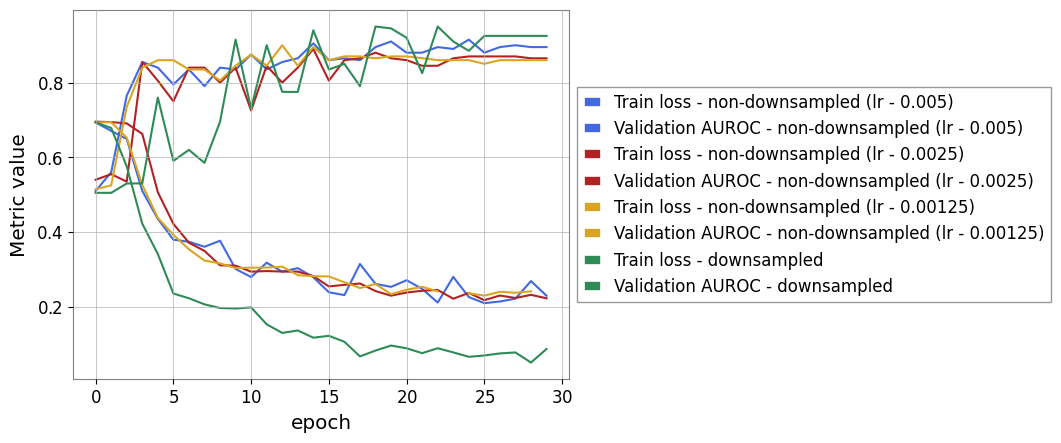

In [13]:
plt.plot(all_metrics[12]['train_epochs'], all_metrics[12]['train_loss'], color = 'royalblue', label="Train loss - non-downsampled (lr - 0.005)")
plt.plot(all_metrics[12]['valid_epochs'], all_metrics[12]['valid_loss'], color = 'royalblue', label="Validation AUROC - non-downsampled (lr - 0.005)")

plt.plot(all_metrics[24]['train_epochs'], all_metrics[24]['train_loss'], color = 'firebrick', label="Train loss - non-downsampled (lr - 0.0025)")
plt.plot(all_metrics[24]['valid_epochs'], all_metrics[24]['valid_loss'], color = 'firebrick',label="Validation AUROC - non-downsampled (lr - 0.0025)")

plt.plot(all_metrics[27]['train_epochs'], all_metrics[27]['train_loss'], color = 'goldenrod', label="Train loss - non-downsampled (lr - 0.00125)")
plt.plot(all_metrics[27]['valid_epochs'], all_metrics[27]['valid_loss'], color = 'goldenrod', label="Validation AUROC - non-downsampled (lr - 0.00125)")

plt.plot(all_metrics[16]['train_epochs'], all_metrics[16]['train_loss'], color = 'seagreen', label="Train loss - downsampled")
plt.plot(all_metrics[16]['valid_epochs'], all_metrics[16]['valid_loss'], color = 'seagreen', label="Validation AUROC - downsampled")

plt.legend()
plt.xlabel("epoch")
plt.ylabel("Metric value")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## ROC Curve - false positive and true positive

In [ ]:
from sklearn.metrics import roc_curve, auc

with h5py.File(data_dir / "test_dataset.hdf5", "r") as f:
    X1 = torch.Tensor(f["X"][:]).to(device)
    y1 = torch.Tensor(f["y"][:]).to(device)

indices = model.build_variable_indices(sr=2048, device=device)
X2 = X1.index_select(dim=-1, index=indices)

y_true = y1.cpu().numpy()

: 

In [ ]:
best_ckpt_path1 = "data/logs/ml4gw-expt/version_12/checkpoints/epoch=29-step=2970.ckpt"


model1 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path1,
    architecture=architecture,
    metric=BinaryAUROC()
)

model1.eval()

with torch.no_grad():
    logits1 = model1(X1) # raw model outputs
    probs1 = torch.sigmoid(logits1) # convert logits to probabilities

y_score1 = probs1.cpu().numpy()

fpr1, tpr1, thresholds1 = roc_curve(y_true, y_score1)
roc_auc1 = auc(fpr1, tpr1)

/home/bhgupta/.conda/envs/mlgw/lib/python3.10/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
best_ckpt_path2 = "data/logs/ml4gw-expt/version_24/checkpoints/epoch=28-step=2871.ckpt"


model2 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path2,
    architecture=architecture,
    metric=BinaryAUROC()
)

model2.eval()

with torch.no_grad():
    logits2 = model2(X1) # raw model outputs
    probs2 = torch.sigmoid(logits2) # convert logits to probabilities

y_score2 = probs2.cpu().numpy()

fpr2, tpr2, thresholds2 = roc_curve(y_true, y_score2)
roc_auc2 = auc(fpr2, tpr2)

In [ ]:
best_ckpt_path3 = "data/logs/ml4gw-expt/version_27/checkpoints/epoch=21-step=2178.ckpt"

model3 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path3,
    architecture=architecture,
    metric=BinaryAUROC()
)

model3.eval()

with torch.no_grad():
    logits3 = model3(X1)
    probs3 = torch.sigmoid(logits3)

y_score3 = probs3.cpu().numpy()

fpr3, tpr3, thresholds3 = roc_curve(y_true, y_score3)
roc_auc3 = auc(fpr3, tpr3)

In [ ]:
best_ckpt_path4 = "data/logs/ml4gw-expt/version_27/checkpoints/epoch=29-step=780.ckpt"

model4 = Ml4gwDetectionModel.load_from_checkpoint(
    best_ckpt_path4,
    architecture=architecture,
    metric=BinaryAUROC()
)

model4.eval()

with torch.no_grad():
    logits4 = model4(X2)
    probs4 = torch.sigmoid(logits4)

y_score4 = probs4.cpu().numpy()

fpr4, tpr4, thresholds4 = roc_curve(y_true, y_score4)
roc_auc4 = auc(fpr4, tpr4)

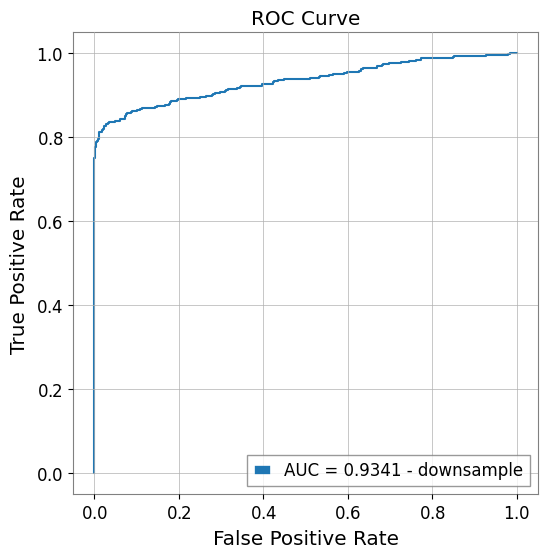

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(fpr1, tpr1, color = 'royalblue', label=f"AUC = {roc_auc1:.4f} - non-downsample (lr - 0.005)")
plt.plot(fpr2, tpr2, color = 'firebrick', label=f"AUC = {roc_auc2:.4f} - non-downsample (lr - 0.0025)")
plt.plot(fpr3, tpr3, color = 'goldenrod', label=f"AUC = {roc_auc3:.4f} - non-downsample (lr - 0.0025)")
plt.plot(fpr4, tpr4, color = 'seagreen', label=f"AUC = {roc_auc4:.4f} - downsample")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()
